In [1]:
# Required library imports
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
import pickle
from sklearn.model_selection import cross_val_score




In [2]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,4a16050093a99092,"No, you have to prove that I can't.",0,0,0,0,0,0
1,6bc2122dc27e275a,Re: My major edit summaries \n\nI have receive...,0,0,0,0,0,0
2,5570f7207bade92f,I depersonalized it. It's sad how you don't ob...,0,0,0,0,0,0
3,a17d6408ffb98139,Thats because I was blocked before I could dis...,0,0,0,0,0,0
4,11b1d25d77ffd834,"I apologise for this, I was just angry with ha...",0,0,0,0,0,0


In [4]:
test_data.head()

,id,comment_text
0,f88f17ce73d55ad9,"Mark Teixiera\nPer WP:CRYSTAL, we only change ..."
1,6a9f4af6d51fc9e2,"""\n\n Reblock \n\nReblock that IP you unblocke..."
2,c44f6d09834d1058,"""::::Censorship isn't an answer. Some things s..."
3,b1b2e8a5731c75d0,This is more fun than acrually editting!! \n\n...
4,f25b7274d05d8290,SarekOfVulcan RFA \n\nThank you for !voting on...


In [5]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111699 entries, 0 to 111698
Data columns (total 8 columns):
id               111699 non-null object
comment_text     111699 non-null object
toxic            111699 non-null int64
severe_toxic     111699 non-null int64
obscene          111699 non-null int64
threat           111699 non-null int64
insult           111699 non-null int64
identity_hate    111699 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.8+ MB


In [7]:
# function to identify comment_text which are clean. 
def clean_comments(row):
    if row['toxic'] == 1:
        return 0
    if row['severe_toxic'] == 1:
        return 0
    if row['obscene'] == 1:
        return 0
    if row['threat'] == 1:
        return 0
    if row['insult'] == 1:
        return 0
    if row['identity_hate'] == 1:
        return 0
    else:
        return 1

In [8]:
# all those comment_text which don't lie in any of the categories
data['Clean'] = data.apply(lambda row : clean_comments(row), axis = 1)

In [9]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Clean
0,4a16050093a99092,"No, you have to prove that I can't.",0,0,0,0,0,0,1
1,6bc2122dc27e275a,Re: My major edit summaries \n\nI have receive...,0,0,0,0,0,0,1
2,5570f7207bade92f,I depersonalized it. It's sad how you don't ob...,0,0,0,0,0,0,1
3,a17d6408ffb98139,Thats because I was blocked before I could dis...,0,0,0,0,0,0,1
4,11b1d25d77ffd834,"I apologise for this, I was just angry with ha...",0,0,0,0,0,0,1


In [10]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

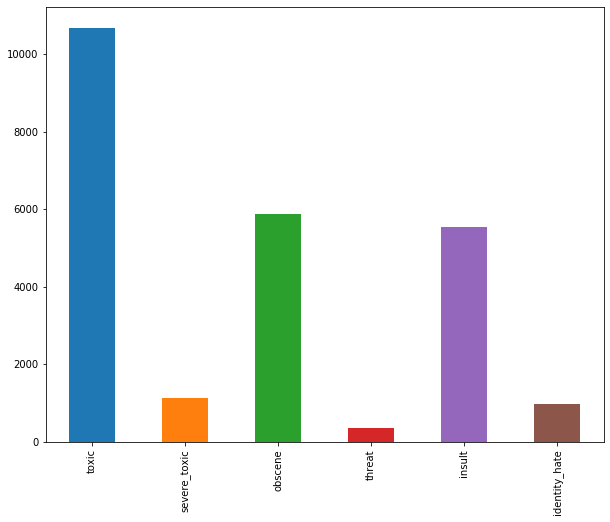

In [11]:

labels = data[class_names]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

labels.sum(axis=0).plot.bar()

In [12]:
corr_matrix = data.corr()

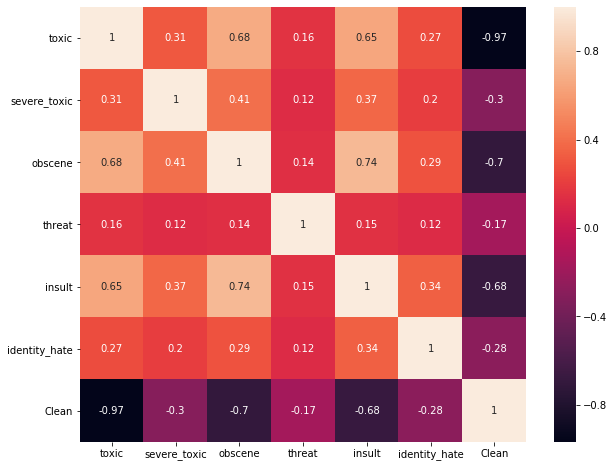

In [13]:
sns.heatmap(corr_matrix, annot = True)

In [14]:
# toxic & obscene
# toxic & insult
# insult & onscene

In [15]:
# text length
def text_len(row):
    return len(row['comment_text'])

In [16]:
data['text_length'] = data.apply(lambda row : text_len(row), axis = 1)

In [17]:
tokenizer = RegexpTokenizer(r'\w+')

First process of pre processing to remmove unwanted html tags, lower the text, and remove punctuations which later create difficulty while creating vectors.

In [18]:
def pre_process_text(sentence):
    
    # lower case
    sentence = sentence.lower()
    
    # Remove html-tags
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', str(sentence))

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
    sentence = sentence.strip()
    sentence = sentence.replace("\n"," ")

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


Remove stop words so that we form better vectors as stop words have a higher frequency and are not much informative.

In [19]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def remove_stopwords(sentence):
    global re_stop_words
    sentence = re_stop_words.sub(" ", sentence)
    
    return sentence

stemming using SnowballStemmer

In [20]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [21]:
def pre_process_apply(row):
    sentence = row['comment_text']
    
    sentence = pre_process_text(sentence)
    sentence = remove_stopwords(sentence)
    sentnece = stemming(sentence)
    
    return sentence

In [22]:
data['processed_comment_text'] = data.apply(lambda row : pre_process_apply(row), axis = 1)

In [23]:
test_data['processed_comment_text'] = data.apply(lambda row : pre_process_apply(row) , axis = 1)

In [37]:
train_text = data['processed_comment_text']
test_text = test_data['processed_comment_text']
all_text = pd.concat([train_text, test_text])

all_text.isnull().sum()

0

In [25]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),min_df=2,max_df=0.5,
    max_features=60000
    )

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [26]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    token_pattern=None,
    min_df=5,
    ngram_range=(2, 4),
    max_features=23000)

char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [29]:
train_features = hstack([train_word_features, train_char_features]).tocsr()
test_features = hstack([test_word_features, test_char_features]).tocsr()

In [30]:
def pr(y_i, y):
    p = train_features[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [31]:
scores = []
submission = pd.DataFrame.from_dict({'Id': test_data['id']})
# classifier1 = LogisticRegression(solver='sag', max_iter=180)
# classifier2 = SGDClassifier(alpha=.00027, max_iter=180, penalty="l2", loss='modified_huber')
# classifier4 = ComplementNB(alpha=0.00027, class_prior=None, fit_prior=False)
# eclassifier = VotingClassifier(estimators=[ ('lr', classifier1), ('sgd', classifier2), ('ComplementNB', classifier4)], voting='soft', weights=[1,0.8,0.6])
"""For using a stacking classifier, do refer to mlextend.ensemble's StackingClassifier"""
for class_name in class_names:
    train_target = data[class_name]
    y = train_target.values
    r = np.log(pr(1,y) / pr(0,y))
    x_nb = train_features.multiply(r)
    l = EasyEnsembleClassifier(base_estimator=LogisticRegression(C=2, solver='sag', max_iter=500))
    n = EasyEnsembleClassifier(base_estimator=SGDClassifier(alpha=.0002, max_iter=180, penalty="l2", loss='modified_huber'))
    o = LogisticRegression(C=2, dual=True, max_iter=500)
    p = RandomForestClassifier(criterion='gini',
            max_depth=100, max_features=1000, max_leaf_nodes=None, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=80)  
    m = VotingClassifier(estimators=[ ('lr', l), ('sgd', n),('lr1',o),('rdf',p)], voting='soft', weights=[0.9,1.35,0.65,0.8])
    m.fit(x_nb, y)
    """For cross validation scores please uncomment the following lines of code"""
    
#     cv_score = np.mean(cross_val_score(
#         m, x_nb, train_target, cv=5, scoring='roc_auc'))
#     scores.append(cv_score)
#     print('CV score for class {} is {}'.format(class_name, cv_score))
# print('Total CV score is {}'.format(np.mean(scores)))
    submission[class_name] = m.predict_proba(test_features.multiply(r))[:, 1]

/home/gandharv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gandharv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gandharv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gandharv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gandharv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

In [32]:
submission.to_csv('EnsembleClassfierSubmission.csv', index=False)